# Evolution Path 
The problem with both Rechenberg and self-adaptation is that they look at one mutation at a time. Rechenberg counts successes over a window; self-adaptation evolves σ alongside x. Both are somewhat myopic - they don’t track where the algorithm has been moving over multiple generations.

The Evolution Path fixes this. Instead of asking “did the last mutation succeed?”, it asks #Q have we been consistently moving in the same direction lately?

### pσ the cumulative path:
The evolution path pσ ∈ Rⁿ is a vector that accumulates recent normalised mutation steps. Think of it as a running memory of where the algorithm has been walking:

pσ ← (1 − cσ)pσ + √(cσ(2 − cσ)) · (x′ − x)/σ     

(x′ − x)/σ is the standardised step taken this generation. cσ ∈ (0,1) is the cumulation rate — how quickly old history fades. The √(cσ(2 − cσ)) factor keeps the expected length of pσ stable.

- If steps consistently point in the same direction → the path grows → we’re confidently progressing → take bigger steps 
- If steps cancel each other out (zigzagging) → the path shrinks → we’re flailing → take smaller steps 

This is more informative than the success rate alone, because direction matters. You could have a high success rate while zigzagging uselessly across a valley, and the evolution path would correctly diagnose this as poor progress

### Step size update 
σ ← σ · exp( (cσ/dσ) · (||pσ|| / E[||N(0,I)||] − 1) )    

dσ > 0 is a damping parameter. The key quantity is ||pσ|| compared to E[||N(0,I)||] ≈ √n — the expected length of a random (uncorrelated) path.
* ||pσ|| > E[||N(0,I)||] → steps are more correlated than random → σ increases
* ||pσ|| < E[||N(0,I)||] → steps are less correlated than random → σ decreases

#Q what happens if cσ = 1.0? The path becomes just the last mutation vector — no memory at all, equivalent to a single-step rule. If cσ = 0.0, the path never updates and σ never changes.

#Q Why compare to E[||N(0,I)||] specifically? Because that's what a random walk looks like. If our path is longer than that, we're doing better than random — genuinely correlated progress — so we should step out more boldly.

In [1]:
pip install cma -q


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cma

# ----- Benchmark functions -----

def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    x = np.array(x)
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))

In [3]:
def one_plus_one_es_classic(fitness_function, N=10, sigma=0.5, max_generations=1000):
    x = np.random.uniform(-5, 5, N)
    history = []

    for _ in range(max_generations):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        print(fitness_function(x))
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
        history.append(fitness_function(x))
        sigma*=0.99

    return x, history


for f in [sphere]:
    x_best, history = one_plus_one_es_classic(f)
    print(f.__name__, "Best fitness:", history[-1])

81.54182541532897
77.65716852018204
76.28738043358227
76.28738043358227
76.28738043358227
76.28738043358227
72.7304751355362
72.7304751355362
66.04346221973518
66.04346221973518
64.03658042258454
60.91171720875444
60.91171720875444
60.91171720875444
60.57816436281213
60.57816436281213
54.30759984653169
45.398317452773014
45.398317452773014
45.398317452773014
45.15663918916253
45.15663918916253
45.15663918916253
45.15663918916253
45.15663918916253
45.034900372863014
34.48025310547763
34.48025310547763
33.00403279192718
33.00403279192718
33.00403279192718
25.696969552961406
25.696969552961406
25.696969552961406
25.696969552961406
25.696969552961406
25.696969552961406
25.696969552961406
24.099117998399308
24.099117998399308
18.59144250643313
18.02845000540919
18.02845000540919
16.183624799796632
16.183624799796632
14.175933439812505
13.626851170789616
13.626851170789616
13.626851170789616
13.246248951008015
13.246248951008015
13.246248951008015
13.246248951008015
9.671769605621897
8.38041

In [4]:
def one_plus_one_es_success_rule(fitness_function, N=10, sigma=0.5, max_generations=2000):
    x = np.random.uniform(-5, 5, N)
    tau = 1.5
    k = 20
    success_count = 0
    history = []

    for t in range(1, max_generations + 1):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
            success_count += 1

        if t % k == 0:
            success_rate = success_count / k
            if success_rate > 1/5:
                sigma *= tau
            else:
                sigma /= tau
            success_count = 0

        history.append(fitness_function(x))

    return x, history


for f in [sphere, rastrigin]:
    x_best, history = one_plus_one_es_success_rule(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 2.320526134355002e-22
rastrigin Best fitness: 96.51022155308185


In [5]:
def mu_plus_lambda_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200, sigma=0.3):
    population = np.random.randn(mu, dim)
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            parent = population[np.random.randint(mu)]
            child = parent + sigma * np.random.randn(dim)
            offspring.append(child)

        combined = np.vstack([population, offspring])
        fitness = np.array([fitness_fn(ind) for ind in combined])
        best_indices = np.argsort(fitness)[:mu]
        population = combined[best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = mu_plus_lambda_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.14509615114249022
rastrigin Best fitness: 27.70568001872185


In [6]:
def self_adaptive_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200):
    tau = 1 / np.sqrt(dim)
    population = [(np.random.randn(dim), 0.5) for _ in range(mu)]
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            x, sigma = population[np.random.randint(mu)]
            sigma_prime = sigma * np.exp(tau * np.random.randn())
            sigma_prime = max(sigma_prime, 1e-8)
            x_prime = x + sigma_prime * np.random.randn(dim)
            offspring.append((x_prime, sigma_prime))

        combined = population + offspring
        fitness = [fitness_fn(ind[0]) for ind in combined]
        best_indices = np.argsort(fitness)[:mu]
        population = [combined[i] for i in best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = self_adaptive_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 2.2936331865381444e-14
rastrigin Best fitness: 15.919329800035484


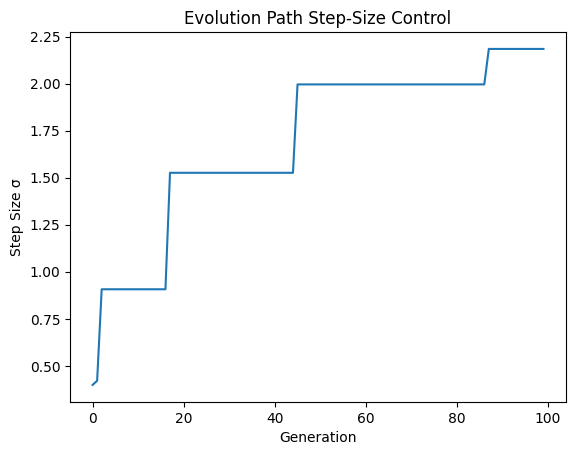

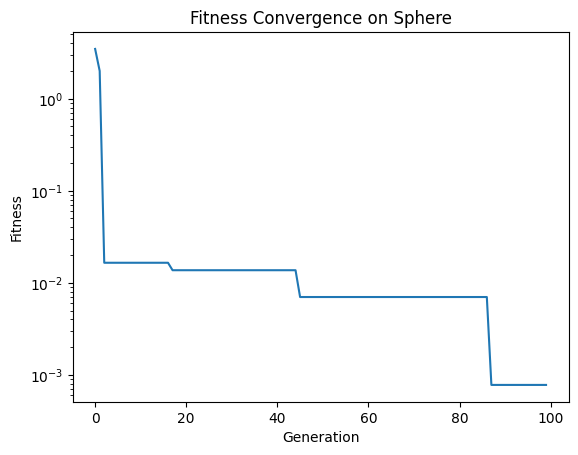

In [7]:
def evolution_path_es(generations=100):
    x = 2.0
    sigma = 0.5
    p_sigma = 0.0
    c_sigma = 0.3
    d_sigma = 1.0
    expected_norm = np.sqrt(2/np.pi)

    sigma_vals = []
    fitness_vals = []

    for _ in range(generations):
        z = np.random.randn()
        x_candidate = x + sigma * z

        # Elitist selection
        if sphere(x_candidate) < sphere(x):
            x = x_candidate
            p_sigma = (1 - c_sigma) * p_sigma + np.sqrt(c_sigma*(2-c_sigma)) * z
            sigma *= np.exp((c_sigma/d_sigma) * (abs(p_sigma)/expected_norm - 1))

        sigma_vals.append(sigma)
        fitness_vals.append(sphere(x))

    return sigma_vals, fitness_vals

sigma_vals, fitness_vals = evolution_path_es()

# Plot step size
plt.figure()
plt.plot(sigma_vals)
plt.xlabel("Generation")
plt.ylabel("Step Size σ")
plt.title("Evolution Path Step-Size Control")
plt.show()

# Plot fitness (log scale)
plt.figure()
plt.plot(fitness_vals)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.yscale("log")
plt.title("Fitness Convergence on Sphere")
plt.show()

In [8]:
def simple_cma_es(fitness_fn, N=10, sigma=0.5, lambda_=10, mu=5, generations=200):
    x = np.random.randn(N)
    C = np.eye(N)
    history = []

    for _ in range(generations):
        A = np.linalg.cholesky(C)
        Z = np.random.randn(lambda_, N)
        X = x + sigma * Z @ A.T
        fitnesses = np.array([fitness_fn(xi) for xi in X])
        indices = np.argsort(fitnesses)
        selected = X[indices[:mu]]
        x_mean = np.mean(selected, axis=0)

        C_update = np.zeros((N,N))
        for xi in selected:
            diff = xi - x_mean
            C_update += np.outer(diff, diff)
        C = 0.8*C + 0.2*(C_update/mu)

        if fitness_fn(x_mean) <= fitness_fn(x):
            x = x_mean

        history.append(fitness_fn(x))

    return x, history


for f in [sphere, rastrigin]:
    best, history = simple_cma_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.2096199481692208
rastrigin Best fitness: 11.908016060479483


In [9]:
def run_pycma(fitness_fn):
    N = 10
    initial_mean = np.random.randn(N)
    initial_sigma = 0.5

    es = cma.CMAEvolutionStrategy(initial_mean, initial_sigma)
    es.optimize(fitness_fn, maxfun=10000)
    print("Best fitness:", es.result.fbest)

print("Sphere:")
run_pycma(sphere)

print("\nRastrigin:")
run_pycma(rastrigin)

Sphere:
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1108686, Tue Feb 24 20:47:26 2026)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 9.596688784156264e+00 1.0e+00 5.05e-01  5e-01  5e-01 0:00.0
    2     20 6.707909196135295e+00 1.3e+00 5.06e-01  5e-01  5e-01 0:00.0
    3     30 7.449036492119389e+00 1.3e+00 4.97e-01  5e-01  5e-01 0:00.0
  100   1000 1.911932599651460e-06 1.8e+00 1.36e-03  5e-04  7e-04 0:00.0
  200   2000 2.579108759238686e-12 1.9e+00 3.24e-06  5e-07  7e-07 0:00.1
  231   2310 1.857873878146664e-14 1.7e+00 3.59e-07  4e-08  6e-08 0:00.1
termination on {'tolfun': 1e-11}
final/bestever f-value = 1.857874e-14 1.857874e-14 after 2310/2303 evaluations
incumbent solution: [-7.98582816e-09 -5.27912346e-08 -3.89534200e-08 -3.37489685e-08
  1.45717717e-08  2.31206828e-09 -1.43853878e-08 -8.48902205e-08 ...]
std deviations: [5.28831656e-08 5.40105600e-08 4.81597268e-08 4.72981745e-08
 5.71944142e-08 4.77692533e-08 4.79737254e-08

# EXERCISES 3 Evolution Path Control (a)(b)

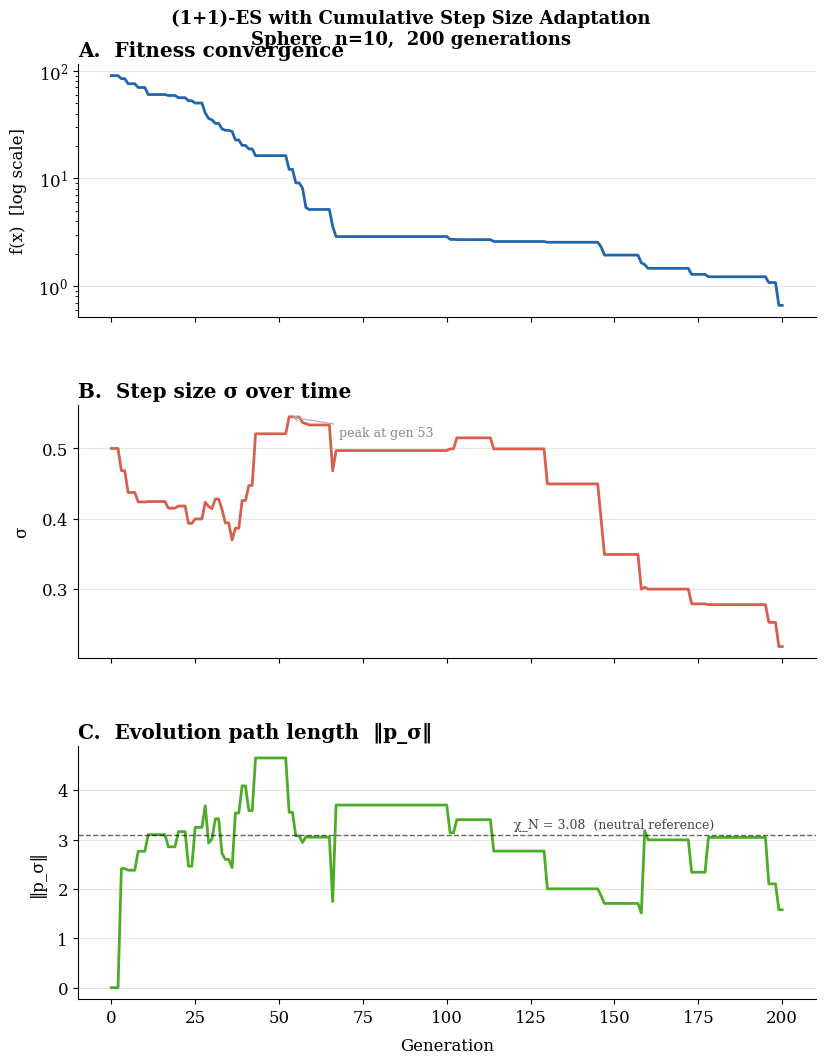

Evolution path plot saved.

Final fitness:  6.596405e-01
Final sigma:    2.178684e-01
Final ||p_σ||:  1.5780  (chi_N = 3.0847)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family":       "serif",
    "font.size":         12,
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "axes.linewidth":    0.8,
    "grid.color":        "#e0e0e0",
    "grid.linewidth":    0.6,
    "lines.linewidth":   2.0,
})

def sphere(x):
    return np.sum(x**2)
def one_plus_one_es_csa(fitness_fn, N=10, sigma_init=0.5, generations=200):
    c_sigma = 0.3          
                           
    d_sigma = 1.0          
    chi_N   = np.sqrt(N) * (1 - 1/(4*N) + 1/(21*N**2))
    x       = np.random.uniform(-5, 5, N)
    sigma   = sigma_init
    p_sigma = np.zeros(N)  
    x_hist       = [x.copy()]
    sigma_hist   = [sigma]
    p_sigma_hist = [p_sigma.copy()]

    for _ in range(generations):
        z       = np.random.randn(N)
        x_prime = x + sigma * z

        if fitness_fn(x_prime) <= fitness_fn(x):
            x = x_prime
            p_sigma = ((1 - c_sigma) * p_sigma
                       + np.sqrt(c_sigma * (2 - c_sigma)) * z)
            sigma = sigma * np.exp(
                (c_sigma / d_sigma) * (np.linalg.norm(p_sigma) / chi_N - 1)
            )
        x_hist.append(x.copy())
        sigma_hist.append(sigma)
        p_sigma_hist.append(p_sigma.copy())
    return (np.array(x_hist),
            np.array(sigma_hist),
            np.array(p_sigma_hist))

# (b)

N    = 10
GENS = 200
np.random.seed(42)

x_hist, sigma_hist, p_sigma_hist = one_plus_one_es_csa(sphere, N=N, generations=GENS)
fitness_hist  = np.array([sphere(x) for x in x_hist])     
p_sigma_norm  = np.linalg.norm(p_sigma_hist, axis=1)      
x_norm        = np.linalg.norm(x_hist, axis=1)           
gens = np.arange(GENS + 1)

# plt 3 panels: fit, σ, evolution path norm

fig, axes = plt.subplots(3, 1, figsize=(9, 11), sharex=True)
fig.subplots_adjust(left=0.13, right=0.95, top=0.93, bottom=0.08, hspace=0.35)
fig.suptitle("(1+1)-ES with Cumulative Step Size Adaptation\n"
             "Sphere  n=10,  200 generations",
             fontsize=13, fontweight="bold")

# fit
ax = axes[0]
ax.semilogy(gens, fitness_hist, color="#2166ac", linewidth=2.0)
ax.set_ylabel("f(x)  [log scale]", labelpad=8)
ax.set_title("A.  Fitness convergence", loc="left", fontweight="bold")
ax.grid(True, which="major", axis="y")
# σ
ax = axes[1]
ax.plot(gens, sigma_hist, color="#d6604d", linewidth=2.0)
ax.set_ylabel("σ", labelpad=8)
ax.set_title("B.  Step size σ over time", loc="left", fontweight="bold")
ax.grid(True, which="major", axis="y")
peak_gen = np.argmax(sigma_hist)
ax.annotate(f"peak at gen {peak_gen}",
            xy=(peak_gen, sigma_hist[peak_gen]),
            xytext=(peak_gen + 15, sigma_hist[peak_gen] * 0.95),
            fontsize=9, color="#888888",
            arrowprops=dict(arrowstyle="->", color="#aaaaaa", lw=0.8))
# evolution path norm 
ax = axes[2]
ax.plot(gens, p_sigma_norm, color="#4dac26", linewidth=2.0,
        label="‖p_σ‖  (evolution path length)")

chi_N = np.sqrt(N) * (1 - 1/(4*N) + 1/(21*N**2))
ax.axhline(chi_N, color="black", linewidth=1.0, linestyle="--", alpha=0.6)
ax.text(GENS * 0.6, chi_N * 1.05,
        f"χ_N = {chi_N:.2f}  (neutral reference)",
        fontsize=9, color="#444444")
ax.set_xlabel("Generation", labelpad=8)
ax.set_ylabel("‖p_σ‖", labelpad=8)
ax.set_title("C.  Evolution path length  ‖p_σ‖", loc="left", fontweight="bold")
ax.grid(True, which="major", axis="y")
plt.show()
plt.close()
print("Evolution path plot saved.")
print(f"\nFinal fitness:  {fitness_hist[-1]:.6e}")
print(f"Final sigma:    {sigma_hist[-1]:.6e}")
print(f"Final ||p_σ||:  {p_sigma_norm[-1]:.4f}  (chi_N = {chi_N:.4f})")

# EXERCISES Penalty Functions (a)(b)(c)(d)

α=0.1     x*=[ 0.0943 -0.0069]  f(x*)=0.0089  feasible=NO
α=1.0     x*=[0.4997 0.0086]  f(x*)=0.2498  feasible=NO
α=10.0    x*=[0.9131 0.0344]  f(x*)=0.8350  feasible=NO
α=1000.0  x*=[0.9992 0.061 ]  f(x*)=1.0021  feasible=yes


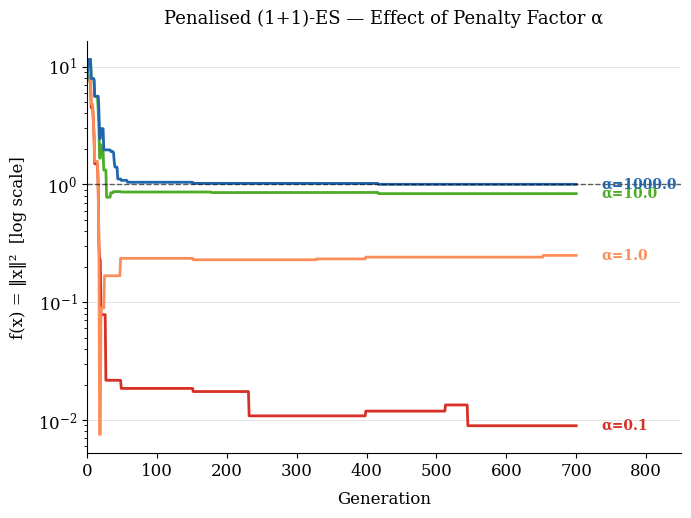

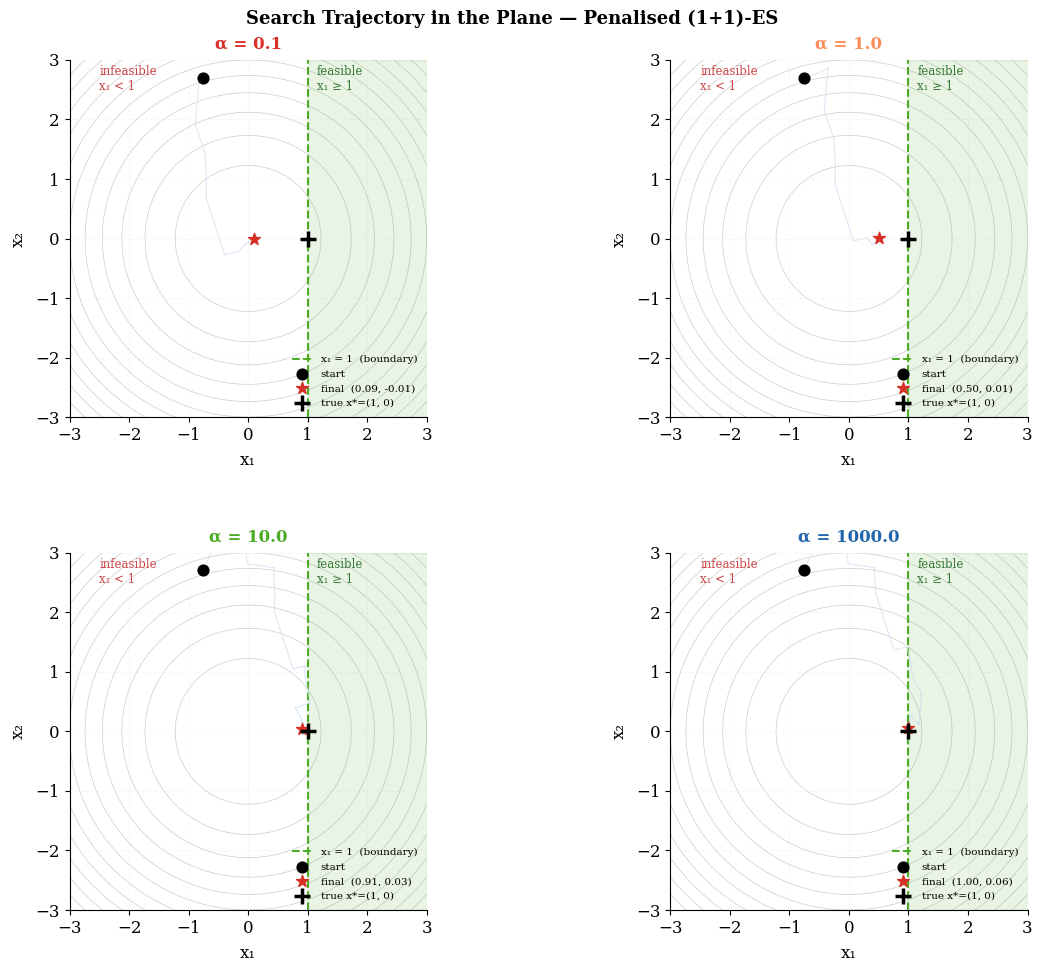

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams.update({
    "font.family":       "serif",
    "font.size":         12,
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "axes.linewidth":    0.8,
    "grid.color":        "#e0e0e0",
    "grid.linewidth":    0.6,
    "lines.linewidth":   2.0,
})

alpha_colors = {0.1: "#d73027", 1.0: "#fc8d59", 10.0: "#4dac26", 1000.0: "#2166ac"}

def f(x):
    return np.sum(x**2)
def g(x):
    return 1.0 - x[0]
def f_penalised(x, alpha):
    return f(x) + alpha * max(0.0, g(x))**2

# (a) + (b) 
def one_plus_one_es(objective, N=2, sigma=0.3, generations=2000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x   = np.random.uniform(-3, 3, N)   
    fit = objective(x)
    fit_hist   = [fit]
    trajectory = [x.copy()]   
    for _ in range(generations):
        x_prime   = x + sigma * np.random.randn(N)
        fit_prime = objective(x_prime)
        if fit_prime <= fit:
            x, fit = x_prime, fit_prime
        fit_hist.append(fit)
        trajectory.append(x.copy())
    return x, np.array(fit_hist), np.array(trajectory)

# (c)
GENS   = 700
ALPHAS = [0.1, 1.0, 10.0, 1000.0]
SEED   = 42
results = {}
for alpha in ALPHAS:
    obj = lambda x, a=alpha: f_penalised(x, a)
    x_opt, fh, traj = one_plus_one_es(obj, generations=GENS, seed=SEED)
    results[alpha]   = x_opt, fh, traj
    print(f"α={alpha:<6}  x*={x_opt.round(4)}  "
          f"f(x*)={f(x_opt):.4f}  "
          f"feasible={'yes' if g(x_opt) <= 1e-3 else 'NO'}")

# Fig 1
gens = np.arange(GENS + 1)
fig, ax = plt.subplots(figsize=(9, 5.5))
fig.subplots_adjust(left=0.12, right=0.78, top=0.88, bottom=0.13)
for alpha in ALPHAS:
    _, _, traj = results[alpha]
    true_fh = np.array([f(x) for x in traj])
    ax.semilogy(gens, true_fh, color=alpha_colors[alpha],
                linestyle='-', linewidth=2.0)
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--", alpha=0.6)
for alpha in ALPHAS:
    _, _, traj = results[alpha]
    true_fh = np.array([f(x) for x in traj])
    ax.annotate(f"α={alpha}", xy=(GENS, true_fh[-1]),
                xytext=(18, 0), textcoords="offset points",
                color=alpha_colors[alpha], fontsize=10,
                va="center", fontweight="bold", annotation_clip=False)

ax.set_xlabel("Generation", labelpad=8)
ax.set_ylabel("f(x) = ‖x‖²  [log scale]", labelpad=8)
ax.set_title("Penalised (1+1)-ES — Effect of Penalty Factor α",
             fontsize=13, pad=12)
ax.grid(True, which="major", axis="y")
ax.set_xlim(0, GENS + 150)
plt.show()
plt.close()

# Fig 2
xg = np.linspace(-3, 3, 300)
yg = np.linspace(-3, 3, 300)
X, Y = np.meshgrid(xg, yg)
Z    = X**2 + Y**2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.38, wspace=0.32,
                    left=0.09, right=0.97, top=0.93, bottom=0.08)
fig.suptitle("Search Trajectory in the Plane — Penalised (1+1)-ES",
             fontsize=13, fontweight="bold", y=0.98)
for ax, alpha in zip(axes.flat, ALPHAS):
    x_opt, _, traj = results[alpha]
    ax.contour(X, Y, Z, levels=15, colors="#cccccc", linewidths=0.5, zorder=1)
    ax.axvspan(1, 3, alpha=0.12, color="#4dac26", zorder=2)
    ax.axvline(1.0, color="#4dac26", linewidth=1.5,
               linestyle="--", zorder=3, label="x₁ = 1  (boundary)")
    ax.text(-2.5, 2.5, "infeasible\nx₁ < 1", fontsize=8.5, color="#cc4444")
    ax.text(1.15, 2.5, "feasible\nx₁ ≥ 1",  fontsize=8.5, color="#337733")
    step   = max(1, len(traj) // 300)
    traj_s = traj[::step]
    n_pts  = len(traj_s)
    cmap_traj = plt.colormaps["Blues"]
    for i in range(n_pts - 1):
        c = cmap_traj(0.2 + 0.8 * i / n_pts)
        ax.plot(traj_s[i:i+2, 0], traj_s[i:i+2, 1],
                color=c, linewidth=0.8, alpha=0.7, zorder=4)
    ax.scatter(*traj[0],  color="black",   s=60, zorder=6,
               marker="o", label="start")
    ax.scatter(*traj[-1], color="#d73027", s=80, zorder=6,
               marker="*", label=f"final  ({x_opt[0]:.2f}, {x_opt[1]:.2f})")
    ax.scatter(1, 0, color="black", s=120, zorder=7,
               marker="+", linewidths=2.5, label="true x*=(1, 0)")
    ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)
    ax.set_xlabel("x₁", labelpad=6)
    ax.set_ylabel("x₂", labelpad=6)
    ax.set_title(f"α = {alpha}", fontsize=12, fontweight="bold",
                 pad=8, color=alpha_colors[alpha])
    ax.set_aspect("equal")
    ax.legend(frameon=False, fontsize=7.5, loc="lower right")
    ax.grid(True, linestyle="--", alpha=0.3)
plt.show()
plt.close()
